In [31]:
import numpy as np 
import time as t
import matplotlib.pyplot as plt
import sympy as sp

In [32]:
# def changeRows(A,b, row1, row2):
#     temp = np.copy(A[row1])
#     A[row1] = A[row2]
#     A[row2] = temp

#     temp_b = b[row1]
#     b[row1] = b[row2]
#     b[row2] = temp_b


def retroSubstitution(A,b):
    n = len(b)
    x = np.zeros(n)
    for i in range(n-1,-1,-1):
        sum_ax = 0
        sum_ax = A[i, i+1:] @ x[i+1:]  
        x[i] = (b[i] - sum_ax) / A[i, i]
    return x


def gaussianElimination(A,b): 
    n = len(b)
    for i in range(n): 
        pivot_index = i + np.argmax(np.abs(A[i:, i]))
        if pivot_index != i:
            A[[i, pivot_index]] = A[[pivot_index, i]]
            b[[i, pivot_index]] = b[[pivot_index, i]]
        if A[i, i] == 0:
            raise ValueError("Singular matrix.")
        multiplier = A[i+1:, i] / A[i, i]
        A[i+1:, i:] -= multiplier[:, None] * A[i, i:]
        b[i+1:] -= multiplier * b[i]
    
    x = retroSubstitution(A, b)
    return x

matrix = np.array([[1,1,1],
                   [2,2,5],
                   [4,6,8]], dtype=float)


b = np.array([8,0,-5], dtype=float)

solution = gaussianElimination(matrix,b)
print(solution)

[21.16666667 -7.83333333 -5.33333333]


Atividade 2

Tempo médio de execução para 3 eliminações: 51.890121 segundos


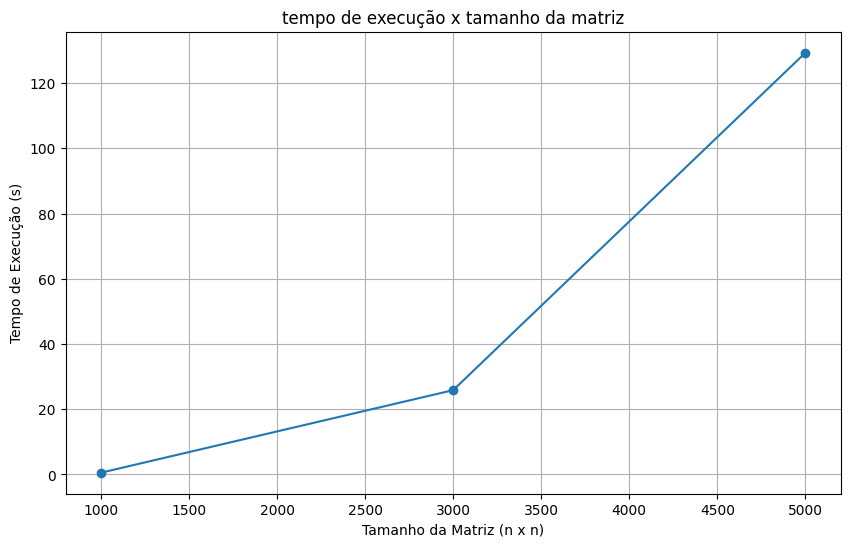

[ 10  31  52  73  94 115 136 157 178 200]


In [16]:
eliminations = 3
a, b = 1000, 5000

n_values = np.linspace(a, b, eliminations, dtype=int)
times = np.zeros(eliminations)
total_time = 0
k = 0
solutions = []

for i in n_values:
    A = np.random.rand(i, i)
    b = np.random.rand(i)

    start_time = t.time()
    solution = gaussianElimination(A, b)
    end_time = t.time()
    times[k] = end_time - start_time
    total_time += times[k]
    k += 1
    solutions.append(solution)  
    
average_time = total_time / eliminations

print(f"Tempo médio de execução para {eliminations} eliminações: {average_time:.6f} segundos")


plt.figure(figsize=(10, 6))
plt.plot(n_values, times, marker='o')
plt.title('tempo de execução x tamanho da matriz')
plt.xlabel('Tamanho da Matriz (n)')
plt.ylabel('Tempo de Execução (s)')
plt.grid()
plt.show()
print(n_values)

Exercício 3

Coeficientes encontrados:
c0 = 3.031741920052795e-06, c1 = 2.4675866256368426

Expressão ajustada: 


Eq(T(n), 3.03174e-6*n**2.46759)

coeficientes via NumPy:  
c0 = 0.000003, c1 = 2.467587


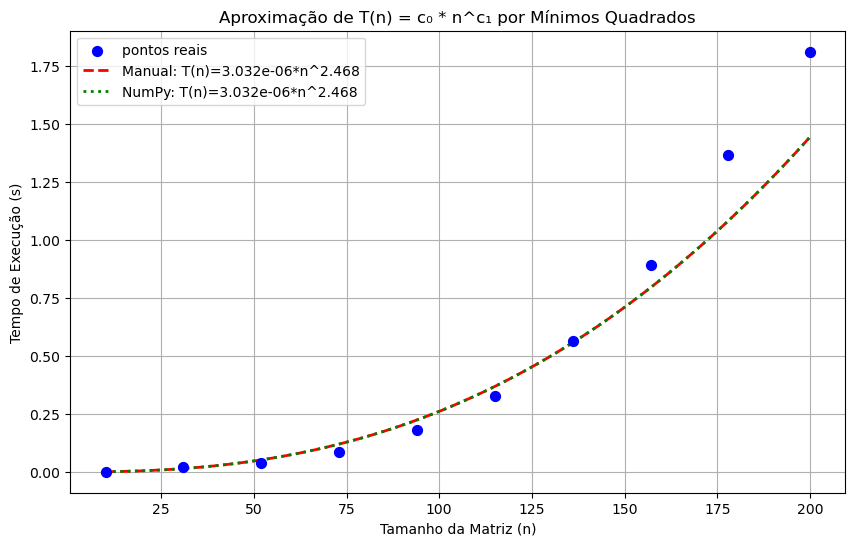

In [21]:
# Aproximação de T(n) = c0 * n^c1 usando linearização logarítmica
x_values = np.array(n_values)
y_values = np.array(times)  # Tempos de execução

# log(T) = log(c0) + c1*log(n)
log_x = np.log(x_values)
log_y = np.log(y_values)

# linear pois já é logaritmo
grau = 1  

# matriz de vandermonde
n_size = len(log_x)
V = np.zeros((n_size, grau + 1))
for i in range(n_size):
    for j in range(grau + 1):
        V[i, j] = log_x[i] ** j


A = np.dot(V.T, V)
b = np.dot(V.T, log_y)


c_manual = gaussianElimination(A, b)
log_c0 = c_manual[0]  # c0 log
c1 = c_manual[1]      # c1 normal
c0 = np.exp(log_c0)   # c0 = e^(log_c0)

print(f"Coeficientes encontrados:\nc0 = {c0}, c1 = {c1}\n")


c0_rounded = float(f"{c0:.6g}")  
c1_rounded = float(f"{c1:.6g}")         

# só pra apresentar melhor
n = sp.symbols('n')
T = sp.Function('T')
T_n = c0_rounded * n**c1_rounded

print("Expressão ajustada: ")
display(sp.Eq(T(n), T_n))

# comparação com np.polyfit
coef_numpy = np.polyfit(log_x, log_y, 1)
c1_numpy = coef_numpy[0]
c0_numpy = np.exp(coef_numpy[1])
print(f"coeficientes via NumPy:  \nc0 = {c0_numpy:.6f}, c1 = {c1_numpy:.6f}")


x_fit = np.linspace(min(x_values), max(x_values), 100)
y_manual = c0 * (x_fit ** c1)
y_numpy = c0_numpy * (x_fit ** c1_numpy)

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, label='pontos reais', color='blue', s=50, zorder=3)
plt.plot(x_fit, y_manual, label=f'Manual: T(n)={c0:.3e}*n^{c1:.3f}', linestyle='--', color='red', linewidth=2)
plt.plot(x_fit, y_numpy, label=f'NumPy: T(n)={c0_numpy:.3e}*n^{c1_numpy:.3f}', linestyle=':', color='green', linewidth=2)
plt.title('Aproximação de T(n) = c₀ * n^c₁ por Mínimos Quadrados')
plt.xlabel('Tamanho da Matriz (n)')
plt.ylabel('Tempo de Execução (s)')
plt.legend()
plt.grid()
plt.show()
